<a href="https://colab.research.google.com/github/dahouda2pro/DTN_Project/blob/master/Bayesian_Opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# Install GPy, GPyOpt
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
!python3 --version
#Python 3.6.9
print(tf.__version__)
#2.3.0
print(K.__version__)
#2.4.0
print(np.__version__)
#1.18.5
#print(matplotlib.__version__)
#3.2.2
print(GPy.__version__)
#1.9.8
print(GPyOpt.__version__)
#1.2.1

Python 3.7.15
2.9.2
2.9.0
1.21.6
1.9.8
1.2.1


In [51]:
def preprocess_data(X, Y):
    """
    function that pre-processes the CIFAR10 dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [52]:
# load the Cifar10 dataset, 50,000 training images and 10,000 test images (here used as validation data)
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()

# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


In [53]:
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
base_model = K.applications.DenseNet201(include_top=False,
                                        weights='imagenet',
                                        input_tensor=resized_images,
                                        input_shape=(224, 224, 3),
                                        pooling='max',
                                        classes=1000)
output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

In [54]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator()
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator()
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

313/313 [==============================] - 41s 133ms/step


In [55]:
def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=10,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  model.compile(
           optimizer=K.optimizers.Adam(learning_rate=learning_rate),
           loss='categorical_crossentropy',
           metrics=['accuracy'])
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('cifar10.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint

In [1]:
def fit_model(model, lr_reduce, early_stop, checkpoint):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=32,
                      epochs=20,
                      verbose=1,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [57]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation



Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 2.00e+00 3.00e-01]]
313/313 [==============================] - 2s 5ms/step - loss: 0.3594 - accuracy: 0.9057
Epoch 1/20
1553/1563 [============================>.] - ETA: 0s - loss: 24.8138 - accuracy: 0.3807
Epoch 1: val_accuracy improved from -inf to 0.67150, saving model to cifar10.h5
1563/1563 [==============================] - 8s 5ms/step - loss: 24.7805 - accuracy: 0.3821 - val_loss: 19.0612 - val_accuracy: 0.6715 - lr: 1.0000e-05
Epoch 2/20
1559/1563 [============================>.] - ETA: 0s - loss: 16.1217 - accuracy: 0.6561
Epoch 2: val_accuracy improved from 0.67150 to 0.77680, saving model to cifar10.h5
1563/1563 [==============================] - 7s 4ms/step - loss: 16.1156 - accuracy: 0.6561 - val_loss: 13.1728 - val_accuracy: 0.7768 - lr: 1.0000e-05
Epoch 3/20
1556/1563 [============================>.] - ETA: 0s - loss: 11.4153 - accuracy: 0.7451
Epoch 3: val_accuracy improved from 0.77680 to 0.81870, saving model to cifar10.

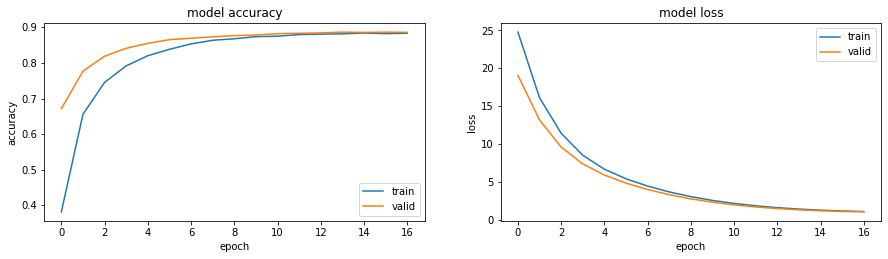


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-01 2.00e+00 7.00e-01]]
313/313 [==============================] - 2s 4ms/step - loss: 0.3594 - accuracy: 0.9057
Epoch 1/20
1553/1563 [============================>.] - ETA: 0s - loss: 2.7949 - accuracy: 0.7075
Epoch 1: val_accuracy improved from -inf to 0.85230, saving model to cifar10.h5
1563/1563 [==============================] - 8s 4ms/step - loss: 2.7855 - accuracy: 0.7080 - val_loss: 1.0727 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 2/20
1563/1563 [==============================] - ETA: 0s - loss: 1.3511 - accuracy: 0.7396
Epoch 2: val_accuracy did not improve from 0.85230
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3511 - accuracy: 0.7396 - val_loss: 1.1365 - val_accuracy: 0.8377 - lr: 0.0010
Epoch 3/20
1554/1563 [============================>.] - ETA: 0s - loss: 1.3934 - accuracy: 0.7289
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.85230

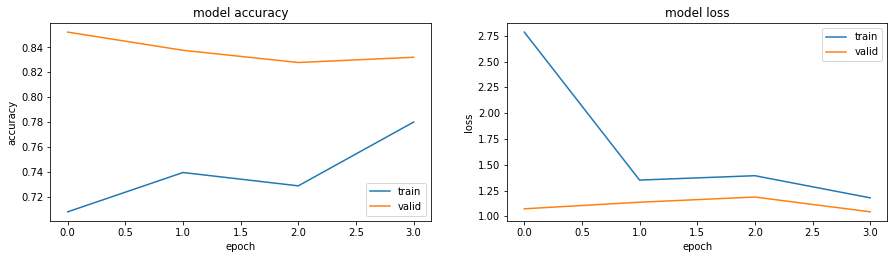


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 2.00e+00 5.00e-01]]
313/313 [==============================] - 1s 3ms/step - loss: 0.3594 - accuracy: 0.9057
Epoch 1/20
1554/1563 [============================>.] - ETA: 0s - loss: 3.0152 - accuracy: 0.7731
Epoch 1: val_accuracy improved from -inf to 0.83120, saving model to cifar10.h5
1563/1563 [==============================] - 8s 5ms/step - loss: 3.0055 - accuracy: 0.7731 - val_loss: 1.0943 - val_accuracy: 0.8312 - lr: 0.0010
Epoch 2/20
1562/1563 [============================>.] - ETA: 0s - loss: 1.2198 - accuracy: 0.7774
Epoch 2: val_accuracy did not improve from 0.83120
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2198 - accuracy: 0.7774 - val_loss: 1.2067 - val_accuracy: 0.7825 - lr: 0.0010
Epoch 3/20
1550/1563 [============================>.] - ETA: 0s - loss: 1.2406 - accuracy: 0.7731
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.83120

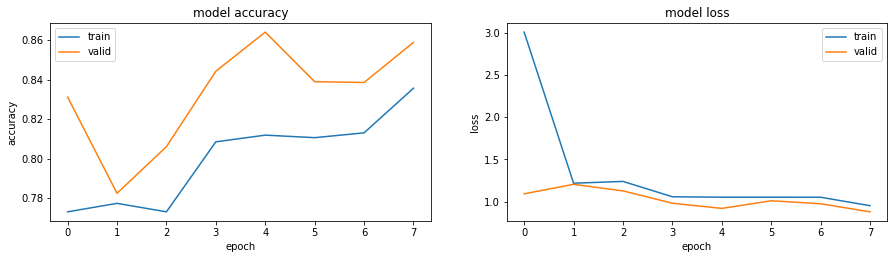


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 1.00e+00 3.00e-01]]
313/313 [==============================] - 1s 3ms/step - loss: 0.3594 - accuracy: 0.9057
Epoch 1/20
1562/1563 [============================>.] - ETA: 0s - loss: 83.2061 - accuracy: 0.4979
Epoch 1: val_accuracy improved from -inf to 0.77220, saving model to cifar10.h5
1563/1563 [==============================] - 8s 5ms/step - loss: 83.1998 - accuracy: 0.4979 - val_loss: 62.5363 - val_accuracy: 0.7722 - lr: 1.0000e-05
Epoch 2/20
1553/1563 [============================>.] - ETA: 0s - loss: 49.0068 - accuracy: 0.7393
Epoch 2: val_accuracy improved from 0.77220 to 0.82880, saving model to cifar10.h5
1563/1563 [==============================] - 6s 4ms/step - loss: 48.9349 - accuracy: 0.7399 - val_loss: 37.0390 - val_accuracy: 0.8288 - lr: 1.0000e-05
Epoch 3/20
1552/1563 [============================>.] - ETA: 0s - loss: 28.9471 - accuracy: 0.7975
Epoch 3: val_accuracy improved from 0.82880 to 0.85290, saving model to cifar10.

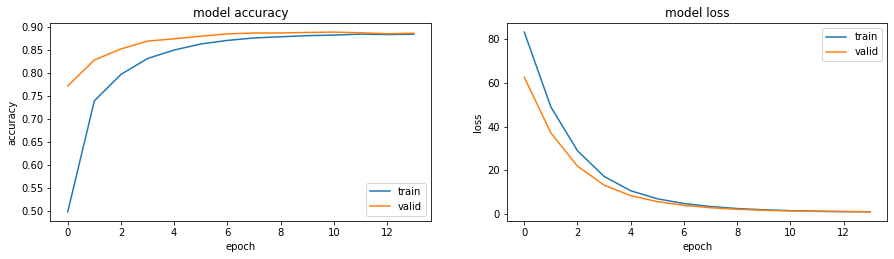


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 1.00e+00 5.00e-01]]
313/313 [==============================] - 1s 3ms/step - loss: 0.3594 - accuracy: 0.9057
Epoch 1/20
1554/1563 [============================>.] - ETA: 0s - loss: 1.3016 - accuracy: 0.7356
Epoch 1: val_accuracy improved from -inf to 0.87330, saving model to cifar10.h5
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2991 - accuracy: 0.7359 - val_loss: 0.6044 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 2/20
1557/1563 [============================>.] - ETA: 0s - loss: 0.7870 - accuracy: 0.8035
Epoch 2: val_accuracy did not improve from 0.87330
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7872 - accuracy: 0.8034 - val_loss: 0.5989 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 3/20
1562/1563 [============================>.] - ETA: 0s - loss: 0.7644 - accuracy: 0.8076
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.87330

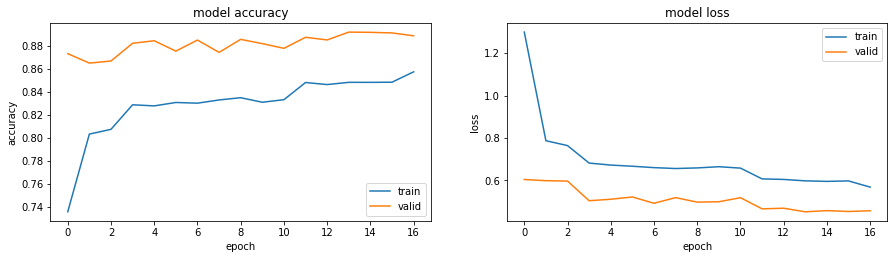




Hyperparameters: [[6.4e+01 1.0e-06 1.0e-02 1.0e+00 7.0e-01]]
313/313 [==============================] - 1s 3ms/step - loss: 0.3594 - accuracy: 0.9057
Epoch 1/20
1560/1563 [============================>.] - ETA: 0s - loss: 10.0623 - accuracy: 0.1036
Epoch 1: val_accuracy improved from -inf to 0.08950, saving model to cifar10.h5
1563/1563 [==============================] - 10s 6ms/step - loss: 10.0593 - accuracy: 0.1037 - val_loss: 5.0825 - val_accuracy: 0.0895 - lr: 1.0000e-06
Epoch 2/20
1563/1563 [==============================] - ETA: 0s - loss: 7.2839 - accuracy: 0.1147
Epoch 2: val_accuracy improved from 0.08950 to 0.11270, saving model to cifar10.h5
1563/1563 [==============================] - 7s 5ms/step - loss: 7.2839 - accuracy: 0.1147 - val_loss: 4.3261 - val_accuracy: 0.1127 - lr: 1.0000e-06
Epoch 3/20
1560/1563 [============================>.] - ETA: 0s - loss: 5.4476 - accuracy: 0.1269
Epoch 3: val_accuracy improved from 0.11270 to 0.14970, saving model to cifar10.h5
1563

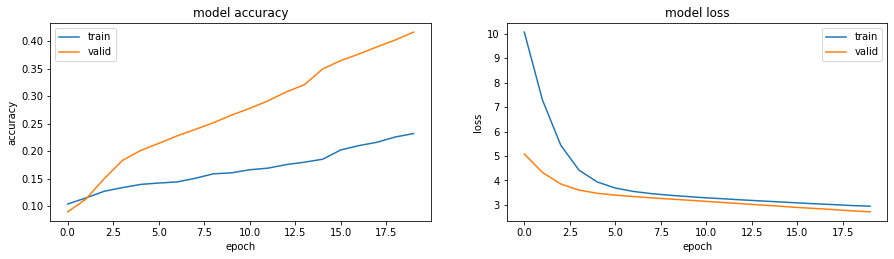


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 1.00e+00 7.00e-01]]
313/313 [==============================] - 1s 3ms/step - loss: 0.3594 - accuracy: 0.9057
Epoch 1/20
1559/1563 [============================>.] - ETA: 0s - loss: 8.7040 - accuracy: 0.1179
Epoch 1: val_accuracy improved from -inf to 0.18140, saving model to cifar10.h5
1563/1563 [==============================] - 8s 5ms/step - loss: 8.7024 - accuracy: 0.1179 - val_loss: 3.9021 - val_accuracy: 0.1814 - lr: 1.0000e-06
Epoch 2/20
1553/1563 [============================>.] - ETA: 0s - loss: 6.6967 - accuracy: 0.1570
Epoch 2: val_accuracy improved from 0.18140 to 0.31200, saving model to cifar10.h5
1563/1563 [==============================] - 7s 5ms/step - loss: 6.6937 - accuracy: 0.1571 - val_loss: 3.1483 - val_accuracy: 0.3120 - lr: 1.0000e-06
Epoch 3/20
1551/1563 [============================>.] - ETA: 0s - loss: 5.3538 - accuracy: 0.2086
Epoch 3: val_accuracy improved from 0.31200 to 0.42700, saving model to cifar10.h5
1563

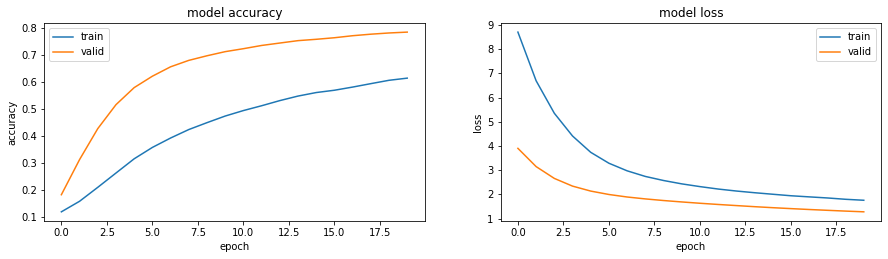

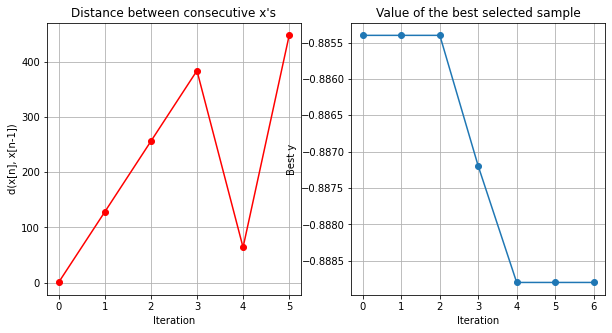

In [58]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)}, {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)}, {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)}, {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)}, {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('cifar10_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],
  evaluation[1]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'cifar10_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'cifar10_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  plot = 0
  def plot_history(history):
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
    #plt.savefig('Loss_Acc_'+str(plot)+'.png')
    #plot = plot + 1
        
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=2, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [59]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4]))
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	128.0
	learning_rate:	0.001
	l2:	0.01
	activation:	relu
	rate:	0.5

optimized accuracy: [0.88880002]


In [60]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('cifar10_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1920)]            0         
                                                                 
 dense_2 (Dense)             (None, 512)               983552    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 988,682
Trainable params: 988,682
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 3ms/step - loss: 0.3594 - accuracy: 0.9057
Restored model, accuracy: 90.57%


In [61]:
best_model.evaluate(features_valid, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3594 - accuracy: 0.9057


[0.3593681752681732, 0.9057000279426575]

In [62]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Fri Nov 18 08:49:33 2022
Optimization completed:      NO,7 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           411.981458902359 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           5
Number continuous variables  0
Number discrete variables    5
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition optim